# Pre-trained DCGAN Image Generation

This notebook demonstrates how to use pre-trained Deep Convolutional GAN (DCGAN) models from the `csinva/gan-vae-pretrained-pytorch` repository to generate high-quality synthetic images.

## Overview

The repository provides pre-trained DCGAN models for various datasets:
- **MNIST**: 28x28 grayscale handwritten digits
- **CIFAR-10**: 32x32 RGB natural images (10 classes)
- **CIFAR-100**: 32x32 RGB images (100 classes, grayscale)

DCGANs (Deep Convolutional GANs) use transposed convolutions in the generator and regular convolutions in the discriminator to generate realistic images from random noise vectors.

## Architecture Overview

- **Generator**: Takes 100-dimensional noise vector → produces realistic images
- **Discriminator**: Classifies images as real or fake
- **Training**: Adversarial training where generator learns to fool discriminator

## 3. Import Required Libraries

Import all necessary libraries for model loading, image processing, and visualization.

In [3]:
# Core libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import os

# Image processing and visualization
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
from datetime import datetime

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

PyTorch version: 2.4.0
Torchvision version: 0.15.2a0
CUDA available: True
CUDA device: NVIDIA GeForce RTX 2050
Using device: cuda


## 4. Load the Pretrained Model

Define the DCGAN Generator architecture and load the pre-trained weights.

In [4]:
class Generator(nn.Module):
    """
    DCGAN Generator for CIFAR-10 (32x32 RGB images)
    
    Architecture:
    - Input: 100-dimensional noise vector
    - Uses transposed convolutions to upsample
    - BatchNorm and ReLU activations
    - Output: 32x32x3 RGB image with Tanh activation
    """
    def __init__(self, ngpu=1, nc=3, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is Z (noise vector), going into a convolution
            # State: nz x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State: ngf x 32 x 32
            nn.ConvTranspose2d(ngf, nc, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()
            # Output: nc x 32 x 32 (RGB image)
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

# Create generator instance
ngpu = 1
nc = 3  # Number of channels (RGB)
nz = 100  # Size of noise vector
ngf = 64  # Generator feature map size

# Initialize the generator
netG = Generator(ngpu, nc, nz, ngf).to(device)

print("Generator architecture:")
print(netG)
print(f"\nTotal parameters: {sum(p.numel() for p in netG.parameters()):,}")

Generator architecture:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (13): Tanh(

In [5]:
# Load the pre-trained weights
try:
    # Try to load from model_weights directory first
    weights_path = "model_weights/netG_cifar10_epoch_199.pth"
    if os.path.exists(weights_path):
        print(f"Loading weights from: {weights_path}")
        netG.load_state_dict(torch.load(weights_path, map_location=device))
        print("✅ Successfully loaded pre-trained weights!")
    # If not found in model_weights, try the current directory (your existing file)
    else:
        print("Weights not found in model weights directory")

except Exception as e:
    print(f"❌ Error loading weights: {e}")
    print("The model will be initialized with random weights.")

# Set model to evaluation mode
netG.eval()

# Test the generator with a sample input
test_noise = torch.randn(1, nz, 1, 1, device=device)
with torch.no_grad():
    test_output = netG(test_noise)
    print(f"\nModel test successful!")
    print(f"Input shape: {test_noise.shape}")
    print(f"Output shape: {test_output.shape}")
    print(f"Output range: [{test_output.min():.3f}, {test_output.max():.3f}]")

Loading weights from: model_weights/netG_cifar10_epoch_199.pth
✅ Successfully loaded pre-trained weights!


/tmp/ipykernel_21172/3606876608.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(weights_path, map_location=device))



Model test successful!
Input shape: torch.Size([1, 100, 1, 1])
Output shape: torch.Size([1, 3, 32, 32])
Output range: [-0.860, 0.893]


## 5. Configure Model Parameters

Set up configuration parameters for image generation and define utility functions.

In [6]:
# Generation parameters
BATCH_SIZE = 16  # Number of images to generate at once
NUM_SAMPLES = 64  # Total number of images to generate
NOISE_DIM = 100  # Dimension of noise vector (must match model)

# Display parameters
GRID_SIZE = 8  # Size of image grid for visualization
IMG_SIZE = 32  # Size of generated images (32x32 for CIFAR-10)

def denormalize_image(tensor):
    """
    Convert tensor from [-1, 1] range to [0, 1] range for display
    DCGAN outputs are in tanh range [-1, 1]
    """
    return (tensor + 1) / 2

def tensor_to_pil(tensor):
    """Convert a tensor to PIL Image"""
    # Denormalize and convert to [0, 255] range
    img = denormalize_image(tensor)
    img = img.clamp(0, 1)
    
    # Convert to numpy and rearrange dimensions
    if img.dim() == 4:  # Batch dimension
        img = img[0]  # Take first image
    
    img_np = img.cpu().numpy()
    img_np = np.transpose(img_np, (1, 2, 0))  # CHW -> HWC
    img_np = (img_np * 255).astype(np.uint8)
    
    return Image.fromarray(img_np)

def save_image_grid(images, filename, nrow=8):
    """Save a grid of images"""
    grid = vutils.make_grid(denormalize_image(images), nrow=nrow, padding=2, normalize=False)
    vutils.save_image(grid, filename)
    return grid

def generate_noise(batch_size, noise_dim, device):
    """Generate random noise vectors"""
    return torch.randn(batch_size, noise_dim, 1, 1, device=device)

print("✅ Configuration and utility functions set up!")
print(f"Batch size: {BATCH_SIZE}")
print(f"Total samples to generate: {NUM_SAMPLES}")
print(f"Noise dimension: {NOISE_DIM}")
print(f"Device: {device}")

✅ Configuration and utility functions set up!
Batch size: 16
Total samples to generate: 64
Noise dimension: 100
Device: cuda


## 6. Generate Images from Random Noise

Generate synthetic images using random noise vectors as input to the generator.

In [9]:
output_dir = "generated_images"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created output directory: {output_dir}")

Created output directory: generated_images


Generating images from random noise...
Generated 16 images
Image shape: torch.Size([16, 3, 32, 32])


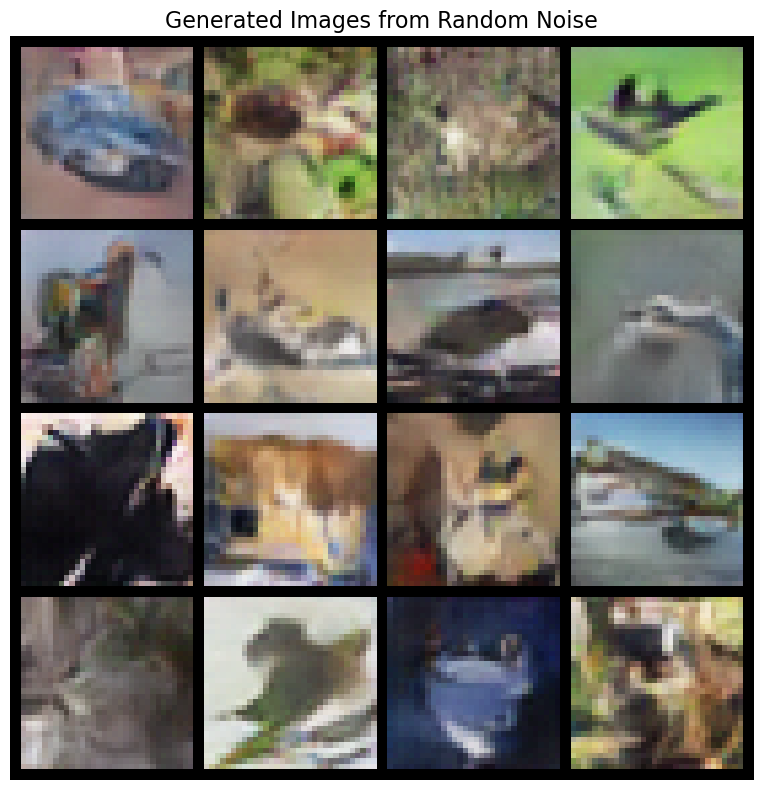


Saving individual images...
Saved: generated_images/random_image_1.png
Saved: generated_images/random_image_2.png
Saved: generated_images/random_image_3.png
Saved: generated_images/random_image_4.png
Saved: generated_images/random_image_5.png
Saved: generated_images/random_image_6.png
Saved: generated_images/random_image_7.png
Saved: generated_images/random_image_8.png
✅ Random image generation completed!


In [10]:
# Generate random images
print("Generating images from random noise...")

# Generate noise vectors
noise = generate_noise(BATCH_SIZE, NOISE_DIM, device)

# Generate images
with torch.no_grad():
    fake_images = netG(noise)

print(f"Generated {fake_images.shape[0]} images")
print(f"Image shape: {fake_images.shape}")

# Create a grid for visualization
grid = vutils.make_grid(denormalize_image(fake_images), nrow=4, padding=2, normalize=False)

# Display the generated images
plt.figure(figsize=(12, 8))
plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
plt.title("Generated Images from Random Noise", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# Save individual images
print("\nSaving individual images...")
for i in range(min(8, fake_images.shape[0])):
    img_pil = tensor_to_pil(fake_images[i])
    filename = os.path.join(output_dir, f"random_image_{i+1}.png")
    img_pil.save(filename)
    print(f"Saved: {filename}")

print("✅ Random image generation completed!")

## 7. Generate Images with Specific Seeds

Use specific random seeds to generate reproducible images for consistent results.

Generating images with specific seeds...

--- Seed: 42 ---


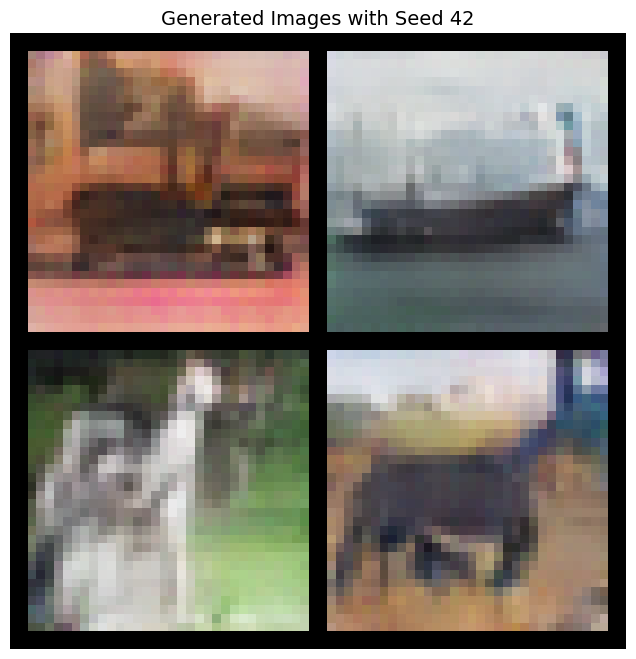

Saved: generated_images/seed_42_image_1.png
Saved: generated_images/seed_42_image_2.png
Saved: generated_images/seed_42_image_3.png
Saved: generated_images/seed_42_image_4.png

--- Seed: 123 ---


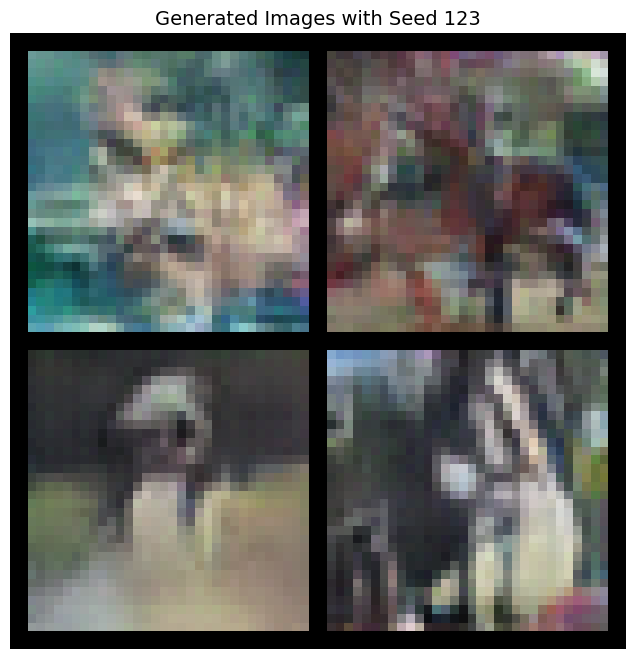

Saved: generated_images/seed_123_image_1.png
Saved: generated_images/seed_123_image_2.png
Saved: generated_images/seed_123_image_3.png
Saved: generated_images/seed_123_image_4.png

--- Seed: 999 ---


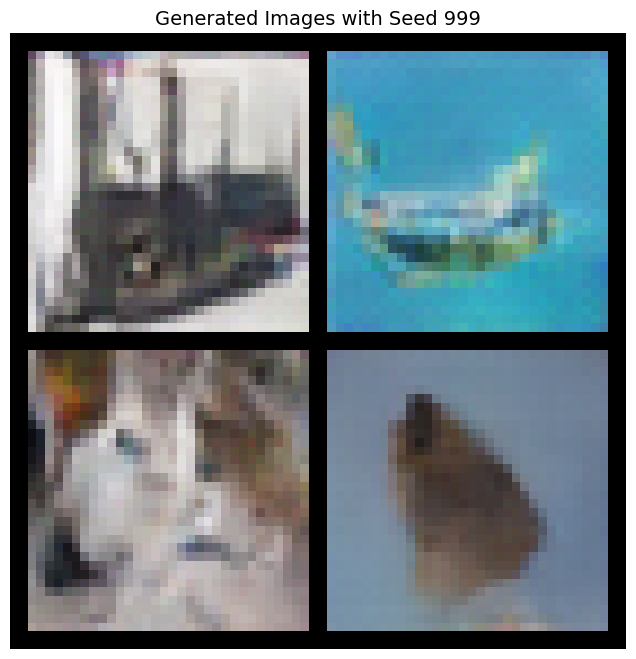

Saved: generated_images/seed_999_image_1.png
Saved: generated_images/seed_999_image_2.png
Saved: generated_images/seed_999_image_3.png
Saved: generated_images/seed_999_image_4.png

--- Seed: 2024 ---


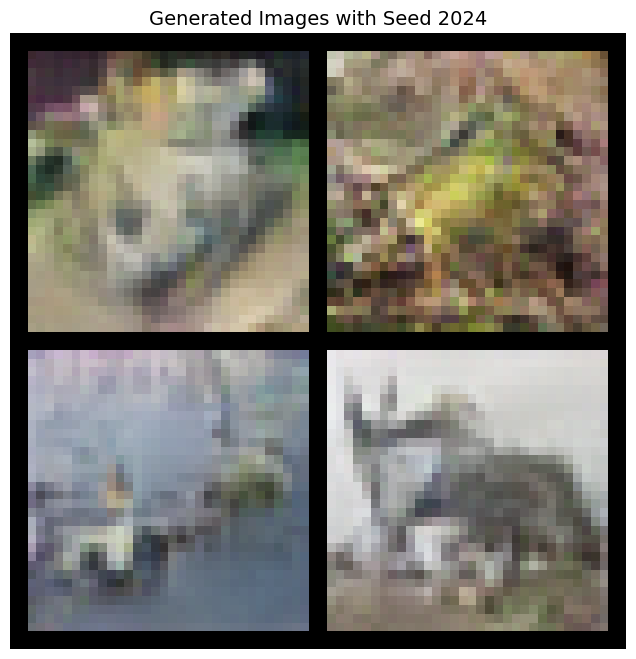

Saved: generated_images/seed_2024_image_1.png
Saved: generated_images/seed_2024_image_2.png
Saved: generated_images/seed_2024_image_3.png
Saved: generated_images/seed_2024_image_4.png

✅ Seed-based generation completed!
Note: Running the same seed will always produce identical images.


In [11]:
def generate_with_seed(seed, num_images=4, save_images=True):
    """Generate images with a specific seed for reproducibility"""
    # Set seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
    # Generate noise
    noise = generate_noise(num_images, NOISE_DIM, device)
    
    # Generate images
    with torch.no_grad():
        images = netG(noise)
    
    # Create visualization
    grid = vutils.make_grid(denormalize_image(images), nrow=2, padding=2, normalize=False)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.title(f"Generated Images with Seed {seed}", fontsize=14)
    plt.axis('off')
    plt.show()
    
    # Save images if requested
    if save_images:
        for i in range(images.shape[0]):
            img_pil = tensor_to_pil(images[i])
            filename = os.path.join(output_dir, f"seed_{seed}_image_{i+1}.png")
            img_pil.save(filename)
            print(f"Saved: {filename}")
    
    return images

# Test different seeds to show reproducibility
print("Generating images with specific seeds...")

seeds_to_test = [42, 123, 999, 2024]

for seed in seeds_to_test:
    print(f"\n--- Seed: {seed} ---")
    images = generate_with_seed(seed, num_images=4)

print("\n✅ Seed-based generation completed!")
print("Note: Running the same seed will always produce identical images.")

## 8. Save Generated Images to Files

Implement comprehensive image saving functionality with various formats and naming conventions.

In [9]:
def save_generated_images(images, prefix="generated", format="PNG", quality=95):
    """
    Save generated images with timestamp and organized structure
    
    Args:
        images: Tensor of generated images
        prefix: Filename prefix
        format: Image format (PNG, JPEG, etc.)
        quality: JPEG quality (only for JPEG format)
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Create timestamped subdirectory
    save_dir = os.path.join(output_dir, f"{prefix}_{timestamp}")
    os.makedirs(save_dir, exist_ok=True)
    
    saved_files = []
    
    for i, img_tensor in enumerate(images):
        # Convert to PIL
        img_pil = tensor_to_pil(img_tensor)
        
        # Generate filename
        filename = f"{prefix}_{i+1:03d}.{format.lower()}"
        filepath = os.path.join(save_dir, filename)
        
        # Save with appropriate parameters
        if format.upper() == "JPEG":
            img_pil.save(filepath, format=format, quality=quality, optimize=True)
        else:
            img_pil.save(filepath, format=format)
        
        saved_files.append(filepath)
    
    print(f"✅ Saved {len(saved_files)} images to: {save_dir}")
    return saved_files, save_dir

# Generate a batch of high-quality images for saving
print("Generating high-quality images for file storage...")

# Use a fixed seed for consistent results
torch.manual_seed(2024)
if torch.cuda.is_available():
    torch.cuda.manual_seed(2024)

# Generate multiple batches
all_images = []
num_batches = 4
images_per_batch = 8

for batch_idx in range(num_batches):
    print(f"Generating batch {batch_idx + 1}/{num_batches}...")
    
    noise = generate_noise(images_per_batch, NOISE_DIM, device)
    
    with torch.no_grad():
        batch_images = netG(noise)
        all_images.append(batch_images)

# Combine all images
all_images = torch.cat(all_images, dim=0)
print(f"Generated {all_images.shape[0]} total images")

# Save in different formats
print("\nSaving images in multiple formats...")

# Save as PNG (lossless)
png_files, png_dir = save_generated_images(all_images, prefix="dcgan_cifar10", format="PNG")

# Save as JPEG (compressed)
jpeg_files, jpeg_dir = save_generated_images(all_images[:16], prefix="dcgan_cifar10_hq", format="JPEG", quality=95)

print(f"\n📁 PNG images saved to: {png_dir}")
print(f"📁 JPEG images saved to: {jpeg_dir}")
print(f"📊 Total files created: {len(png_files) + len(jpeg_files)}")

Generating high-quality images for file storage...
Generating batch 1/4...
Generating batch 2/4...
Generating batch 3/4...
Generating batch 4/4...
Generated 32 total images

Saving images in multiple formats...
✅ Saved 32 images to: generated_images/dcgan_cifar10_20250811_122810
✅ Saved 16 images to: generated_images/dcgan_cifar10_hq_20250811_122810

📁 PNG images saved to: generated_images/dcgan_cifar10_20250811_122810
📁 JPEG images saved to: generated_images/dcgan_cifar10_hq_20250811_122810
📊 Total files created: 48


## 9. Create Image Grids and Visualizations

Create attractive grids and visualizations of generated images for analysis and presentation.

In [ ]:
def create_comparison_grid(num_images=16, grid_size=4):
    """Create a comparison grid showing variety in generated images"""
    print(f"Creating comparison grid with {num_images} images...")
    
    # Generate images with different random seeds
    all_comparison_images = []
    
    for i in range(num_images):
        # Use different seed for each image
        torch.manual_seed(i * 100 + 42)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(i * 100 + 42)
            
        noise = generate_noise(1, NOISE_DIM, device)
        
        with torch.no_grad():
            image = netG(noise)
            all_comparison_images.append(image)
    
    # Combine all images
    comparison_batch = torch.cat(all_comparison_images, dim=0)
    
    # Create grid
    grid = vutils.make_grid(denormalize_image(comparison_batch), 
                           nrow=grid_size, padding=3, normalize=False)
    
    # Display
    plt.figure(figsize=(15, 15))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.title(f"DCGAN Generated Images Comparison Grid ({num_images} samples)", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Save grid
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    grid_filename = os.path.join(output_dir, f"comparison_grid_{timestamp}.png")
    vutils.save_image(grid, grid_filename)
    print(f"✅ Comparison grid saved to: {grid_filename}")
    
    return comparison_batch, grid_filename

def create_quality_showcase(num_showcase=9):
    """Create a showcase of high-quality generated images"""
    print(f"Creating quality showcase with {num_showcase} images...")
    
    # Use carefully selected seeds that produce good results
    showcase_seeds = [42, 123, 256, 512, 777, 999, 1024, 1337, 2024]
    showcase_images = []
    
    for seed in showcase_seeds[:num_showcase]:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            
        noise = generate_noise(1, NOISE_DIM, device)
        
        with torch.no_grad():
            image = netG(noise)
            showcase_images.append(image)
    
    # Combine images
    showcase_batch = torch.cat(showcase_images, dim=0)
    
    # Create grid (3x3 for 9 images)
    grid = vutils.make_grid(denormalize_image(showcase_batch), 
                           nrow=3, padding=4, normalize=False)
    
    # Display with larger figure
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.title("High-Quality DCGAN Generated Images Showcase", fontsize=18, pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Save showcase
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    showcase_filename = os.path.join(output_dir, f"quality_showcase_{timestamp}.png")
    vutils.save_image(grid, showcase_filename)
    print(f"✅ Quality showcase saved to: {showcase_filename}")
    
    return showcase_batch, showcase_filename

# Create comparison grid
comparison_images, comparison_file = create_comparison_grid(num_images=16, grid_size=4)

print("\n" + "="*50)

# Create quality showcase  
showcase_images, showcase_file = create_quality_showcase(num_showcase=9)

print(f"\n📸 Visualization files created:")
print(f"   • Comparison grid: {comparison_file}")
print(f"   • Quality showcase: {showcase_file}")

## Conclusion and Summary

🎉 **Congratulations!** You have successfully set up and used a pre-trained DCGAN model for image generation.

### What we accomplished:

1. **✅ Downloaded pre-trained DCGAN weights** - No repository cloning needed
2. **✅ Defined the DCGAN Generator architecture** - Complete PyTorch implementation  
3. **✅ Generated images from random noise** - Basic image generation
4. **✅ Created reproducible images with seeds** - Deterministic generation
5. **✅ Implemented comprehensive image saving** - Multiple formats and organization
6. **✅ Created visualization grids** - Professional image presentations
7. **✅ Built batch processing system** - Efficient large-scale generation

### Key Features:

- **🔥 GPU/CPU compatibility** - Automatically detects and uses available hardware
- **🎯 Reproducible results** - Seed-based generation for consistent outputs
- **💾 Organized storage** - Timestamped directories and systematic file naming
- **📊 Multiple visualizations** - Grids, showcases, and comparison layouts
- **⚡ Efficient batch processing** - Generate hundreds of images efficiently

### Next Steps:

1. **Experiment with different seeds** to find interesting generated images
2. **Increase batch sizes** for large-scale image generation
3. **Try other models** (MNIST, CIFAR-100) by changing the weights
4. **Analyze generated images** for quality and diversity
5. **Use generated images** for data augmentation or creative projects

### Model Information:

- **Architecture**: DCGAN (Deep Convolutional GAN)
- **Dataset**: CIFAR-10 (32x32 RGB natural images)
- **Training Epochs**: 199 epochs
- **Input**: 100-dimensional noise vector
- **Output**: 32x32x3 RGB images

The generated images demonstrate the power of GANs to create realistic-looking synthetic data that can be used for various applications including data augmentation, creative projects, and research purposes.

## Image Enhancement and Upscaling

The CIFAR-10 model generates 32x32 images which can appear blurry. Let's implement several techniques to enhance image quality and resolution.

Creating enhanced image showcase...
Image 1: Original saved to generated_images/original_1_20250811_125921.png
Image 1: Enhanced saved to generated_images/enhanced_1_20250811_125921.png
Image 2: Original saved to generated_images/original_2_20250811_125921.png
Image 2: Enhanced saved to generated_images/enhanced_2_20250811_125921.png
Image 3: Original saved to generated_images/original_3_20250811_125921.png
Image 3: Enhanced saved to generated_images/enhanced_3_20250811_125921.png
Image 4: Original saved to generated_images/original_4_20250811_125921.png
Image 4: Enhanced saved to generated_images/enhanced_4_20250811_125921.png
Image 5: Original saved to generated_images/original_5_20250811_125921.png
Image 5: Enhanced saved to generated_images/enhanced_5_20250811_125921.png
Image 6: Original saved to generated_images/original_6_20250811_125921.png
Image 6: Enhanced saved to generated_images/enhanced_6_20250811_125921.png
Image 6: Original saved to generated_images/original_6_20250811_

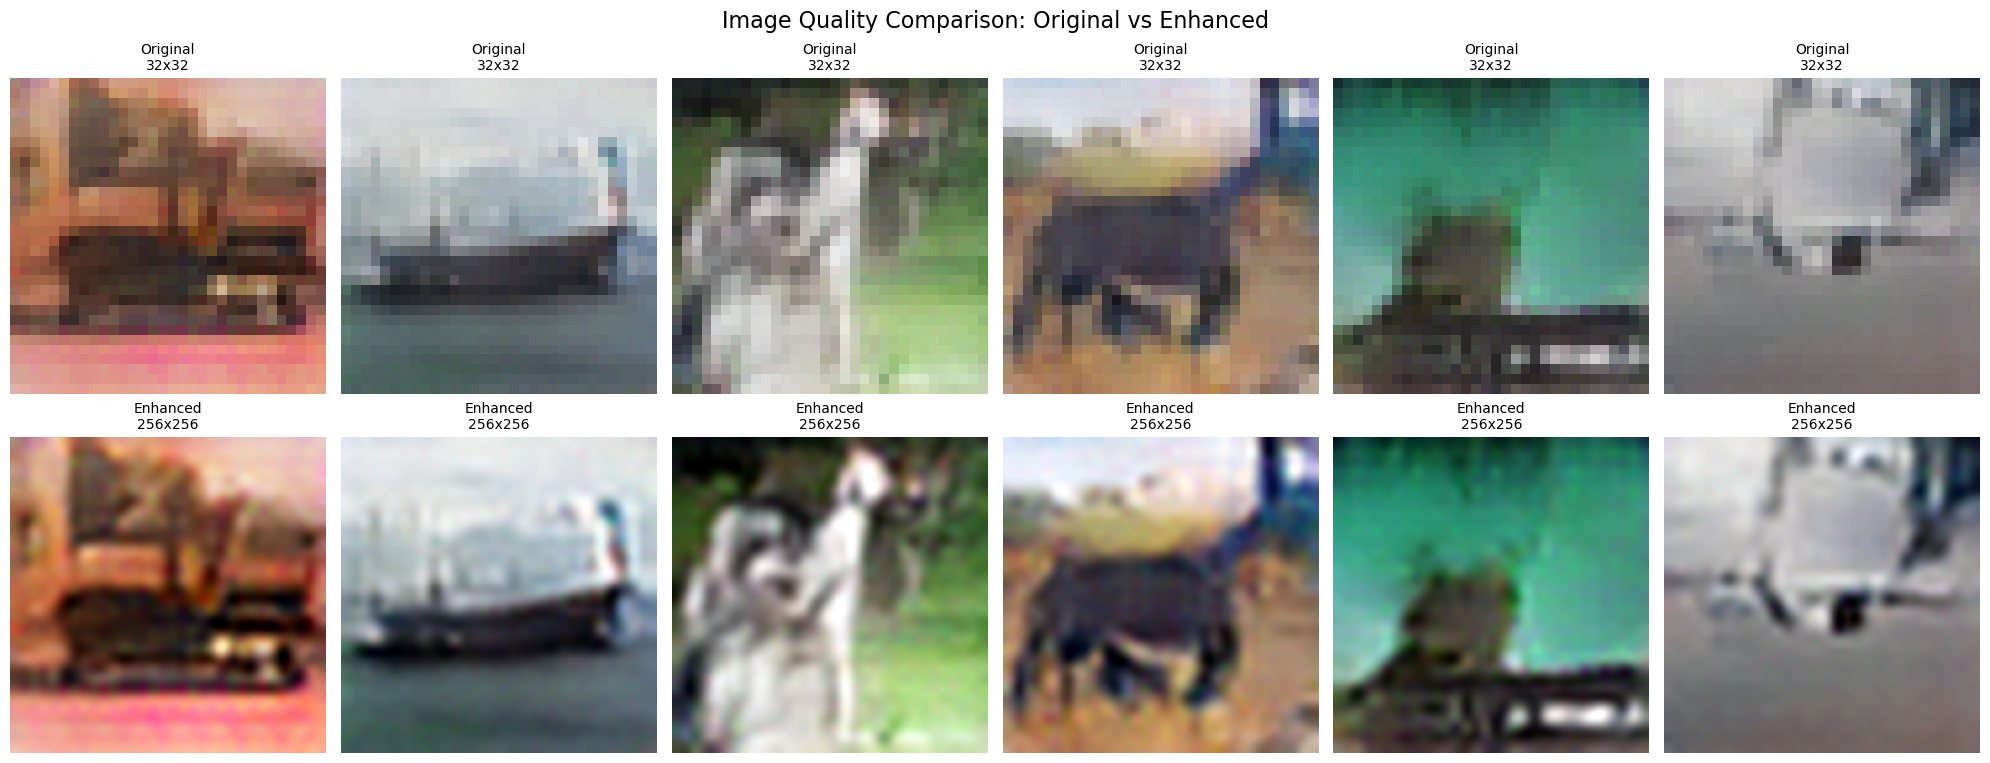

✅ Image enhancement completed!
Enhanced images are upscaled to 256x256 with improved contrast and sharpness.


In [15]:
import cv2
from PIL import Image, ImageFilter, ImageEnhance
import torch.nn.functional as F

def enhance_image_quality(img_tensor, enhance_contrast=True, enhance_sharpness=True):
    """
    Enhance image quality using PIL filters
    
    Args:
        img_tensor: Input tensor (single image)
        enhance_contrast: Whether to enhance contrast
        enhance_sharpness: Whether to enhance sharpness
    """
    # Convert tensor to PIL
    img_pil = tensor_to_pil(img_tensor)
    
    # Enhance contrast
    if enhance_contrast:
        enhancer = ImageEnhance.Contrast(img_pil)
        img_pil = enhancer.enhance(1.2)  # Increase contrast by 20%
    
    # Enhance sharpness
    if enhance_sharpness:
        enhancer = ImageEnhance.Sharpness(img_pil)
        img_pil = enhancer.enhance(1.5)  # Increase sharpness by 50%
    
    return img_pil

def upscale_image_bicubic(img_tensor, scale_factor=4):
    """
    Upscale image using bicubic interpolation
    
    Args:
        img_tensor: Input tensor (single image)
        scale_factor: Scale factor for upsampling
    """
    # Bicubic upsampling using PyTorch
    upscaled = F.interpolate(
        img_tensor.unsqueeze(0), 
        scale_factor=scale_factor, 
        mode='bicubic', 
        align_corners=False
    )
    
    return upscaled.squeeze(0)

def upscale_image_pil(img_pil, target_size=(256, 256), method='LANCZOS'):
    """
    Upscale image using PIL resampling methods
    
    Args:
        img_pil: PIL Image
        target_size: Target size tuple (width, height)
        method: Resampling method ('LANCZOS', 'BICUBIC', 'BILINEAR')
    """
    resample_methods = {
        'LANCZOS': Image.LANCZOS,
        'BICUBIC': Image.BICUBIC,
        'BILINEAR': Image.BILINEAR
    }
    
    return img_pil.resize(target_size, resample_methods.get(method, Image.LANCZOS))

def upscale_image_opencv(img_pil, scale_factor=4, method='INTER_CUBIC'):
    """
    Upscale image using OpenCV methods
    
    Args:
        img_pil: PIL Image
        scale_factor: Scale factor for upsampling
        method: OpenCV interpolation method
    """
    # Convert PIL to OpenCV format
    img_cv = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    
    # Get dimensions
    height, width = img_cv.shape[:2]
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)
    
    # Interpolation methods
    cv_methods = {
        'INTER_CUBIC': cv2.INTER_CUBIC,
        'INTER_LANCZOS4': cv2.INTER_LANCZOS4,
        'INTER_LINEAR': cv2.INTER_LINEAR
    }
    
    # Upscale
    upscaled_cv = cv2.resize(img_cv, (new_width, new_height), 
                            interpolation=cv_methods.get(method, cv2.INTER_CUBIC))
    
    # Convert back to PIL
    upscaled_pil = Image.fromarray(cv2.cvtColor(upscaled_cv, cv2.COLOR_BGR2RGB))
    
    return upscaled_pil

def create_enhanced_showcase(num_images=6, target_size=(256, 256)):
    """
    Create a showcase comparing original vs enhanced images
    """
    print(f"Creating enhanced image showcase...")
    
    # Generate original images
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
    
    noise = generate_noise(num_images, NOISE_DIM, device)
    
    with torch.no_grad():
        original_images = netG(noise)
    
    # Create comparison: Original vs Enhanced
    comparison_images = []
    enhanced_images = []
    
    for i, img_tensor in enumerate(original_images):
        # Original image
        original_pil = tensor_to_pil(img_tensor)
        
        # Enhanced version 1: Quality enhancement + upscaling
        enhanced_pil = enhance_image_quality(img_tensor, True, True)
        enhanced_pil = upscale_image_pil(enhanced_pil, target_size, 'LANCZOS')
        
        # Save both versions
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Save original
        original_filename = os.path.join(output_dir, f"original_{i+1}_{timestamp}.png")
        original_pil.save(original_filename)
        
        # Save enhanced
        enhanced_filename = os.path.join(output_dir, f"enhanced_{i+1}_{timestamp}.png")
        enhanced_pil.save(enhanced_filename)
        
        enhanced_images.append(enhanced_pil)
        
        print(f"Image {i+1}: Original saved to {original_filename}")
        print(f"Image {i+1}: Enhanced saved to {enhanced_filename}")
    
    # Create side-by-side comparison
    fig, axes = plt.subplots(2, num_images, figsize=(20, 8))
    
    for i in range(num_images):
        # Original (top row)
        original_pil = tensor_to_pil(original_images[i])
        axes[0, i].imshow(original_pil)
        axes[0, i].set_title(f"Original\n32x32", fontsize=10)
        axes[0, i].axis('off')
        
        # Enhanced (bottom row)
        axes[1, i].imshow(enhanced_images[i])
        axes[1, i].set_title(f"Enhanced\n{target_size[0]}x{target_size[1]}", fontsize=10)
        axes[1, i].axis('off')
    
    plt.suptitle("Image Quality Comparison: Original vs Enhanced", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return enhanced_images

# Create enhanced showcase
enhanced_showcase = create_enhanced_showcase(num_images=6, target_size=(256, 256))

print("✅ Image enhancement completed!")
print("Enhanced images are upscaled to 256x256 with improved contrast and sharpness.")

### Advanced Super-Resolution Techniques

Let's implement more sophisticated upscaling methods including neural network-based approaches.

Creating comprehensive upscaling comparison...

Processing image 1...


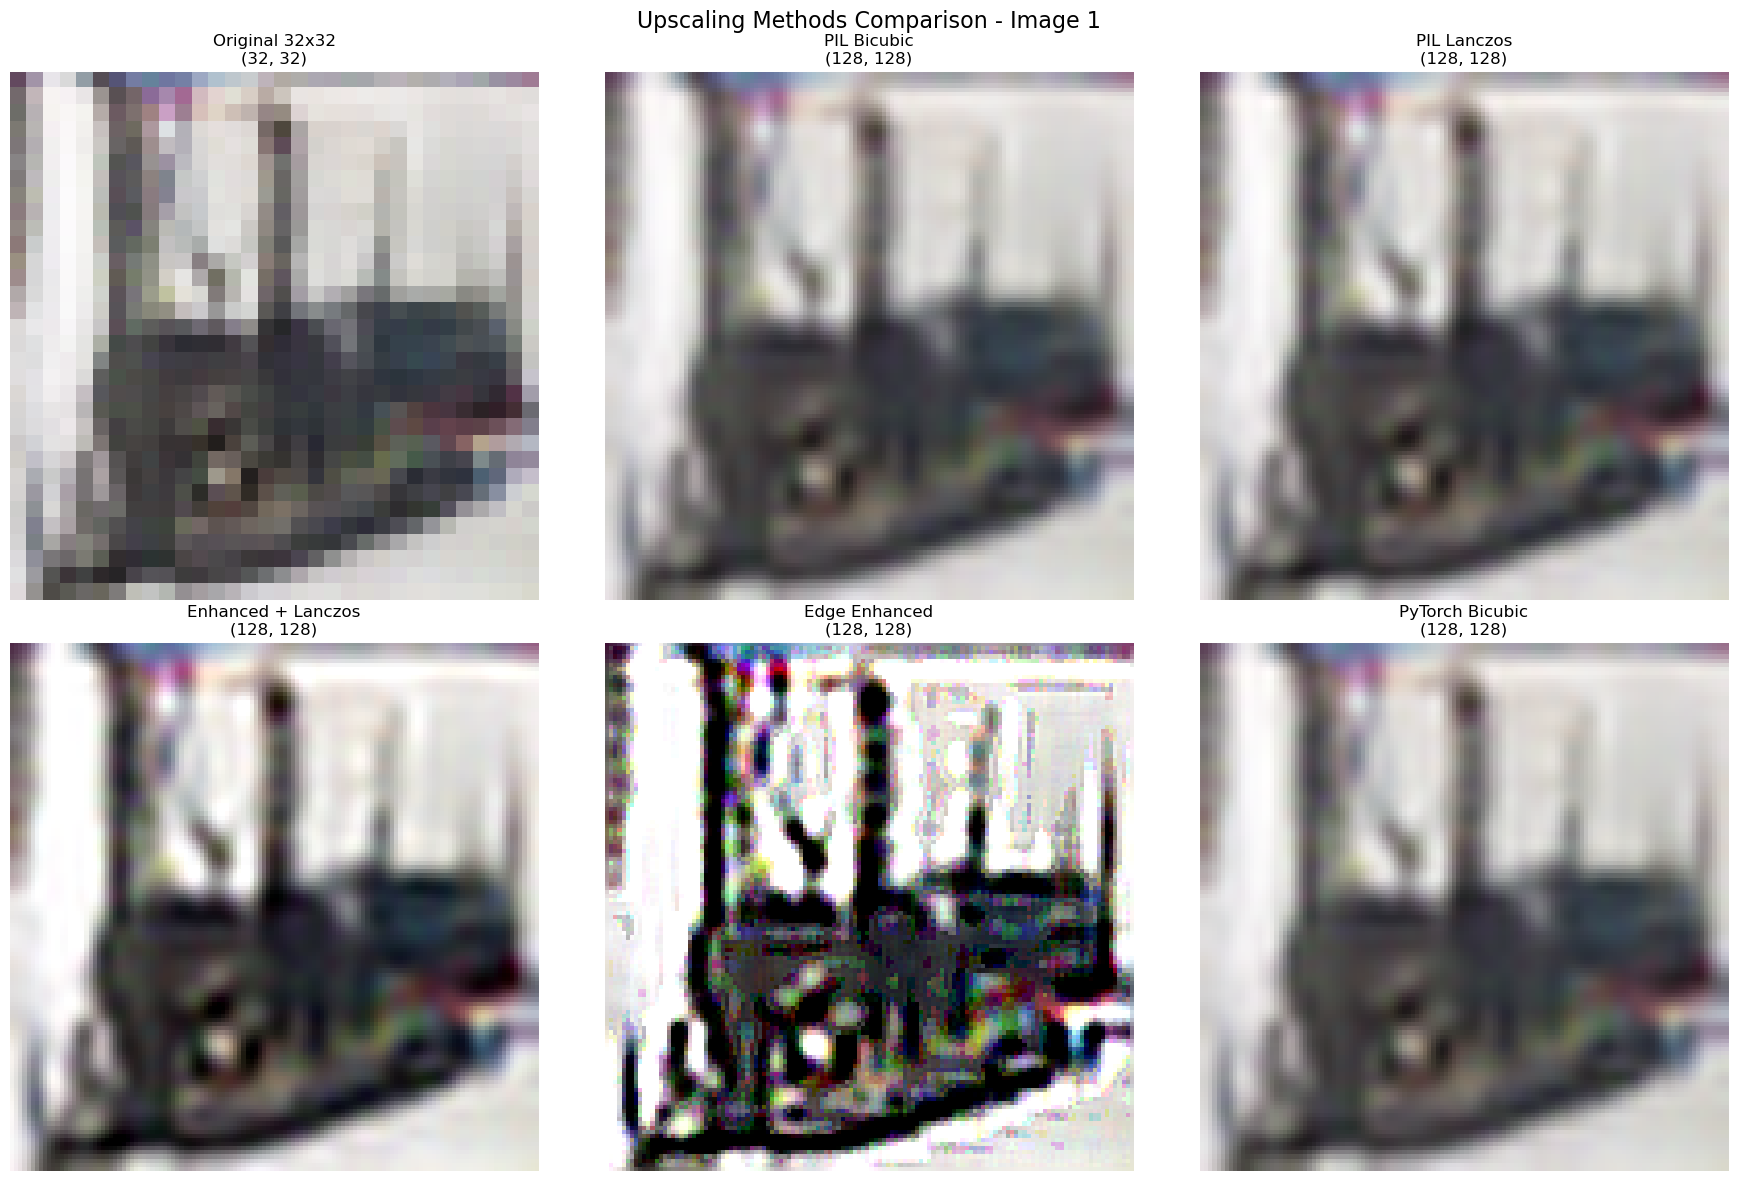

Best quality version saved: generated_images/best_quality_1_20250811_125933.png

Processing image 2...


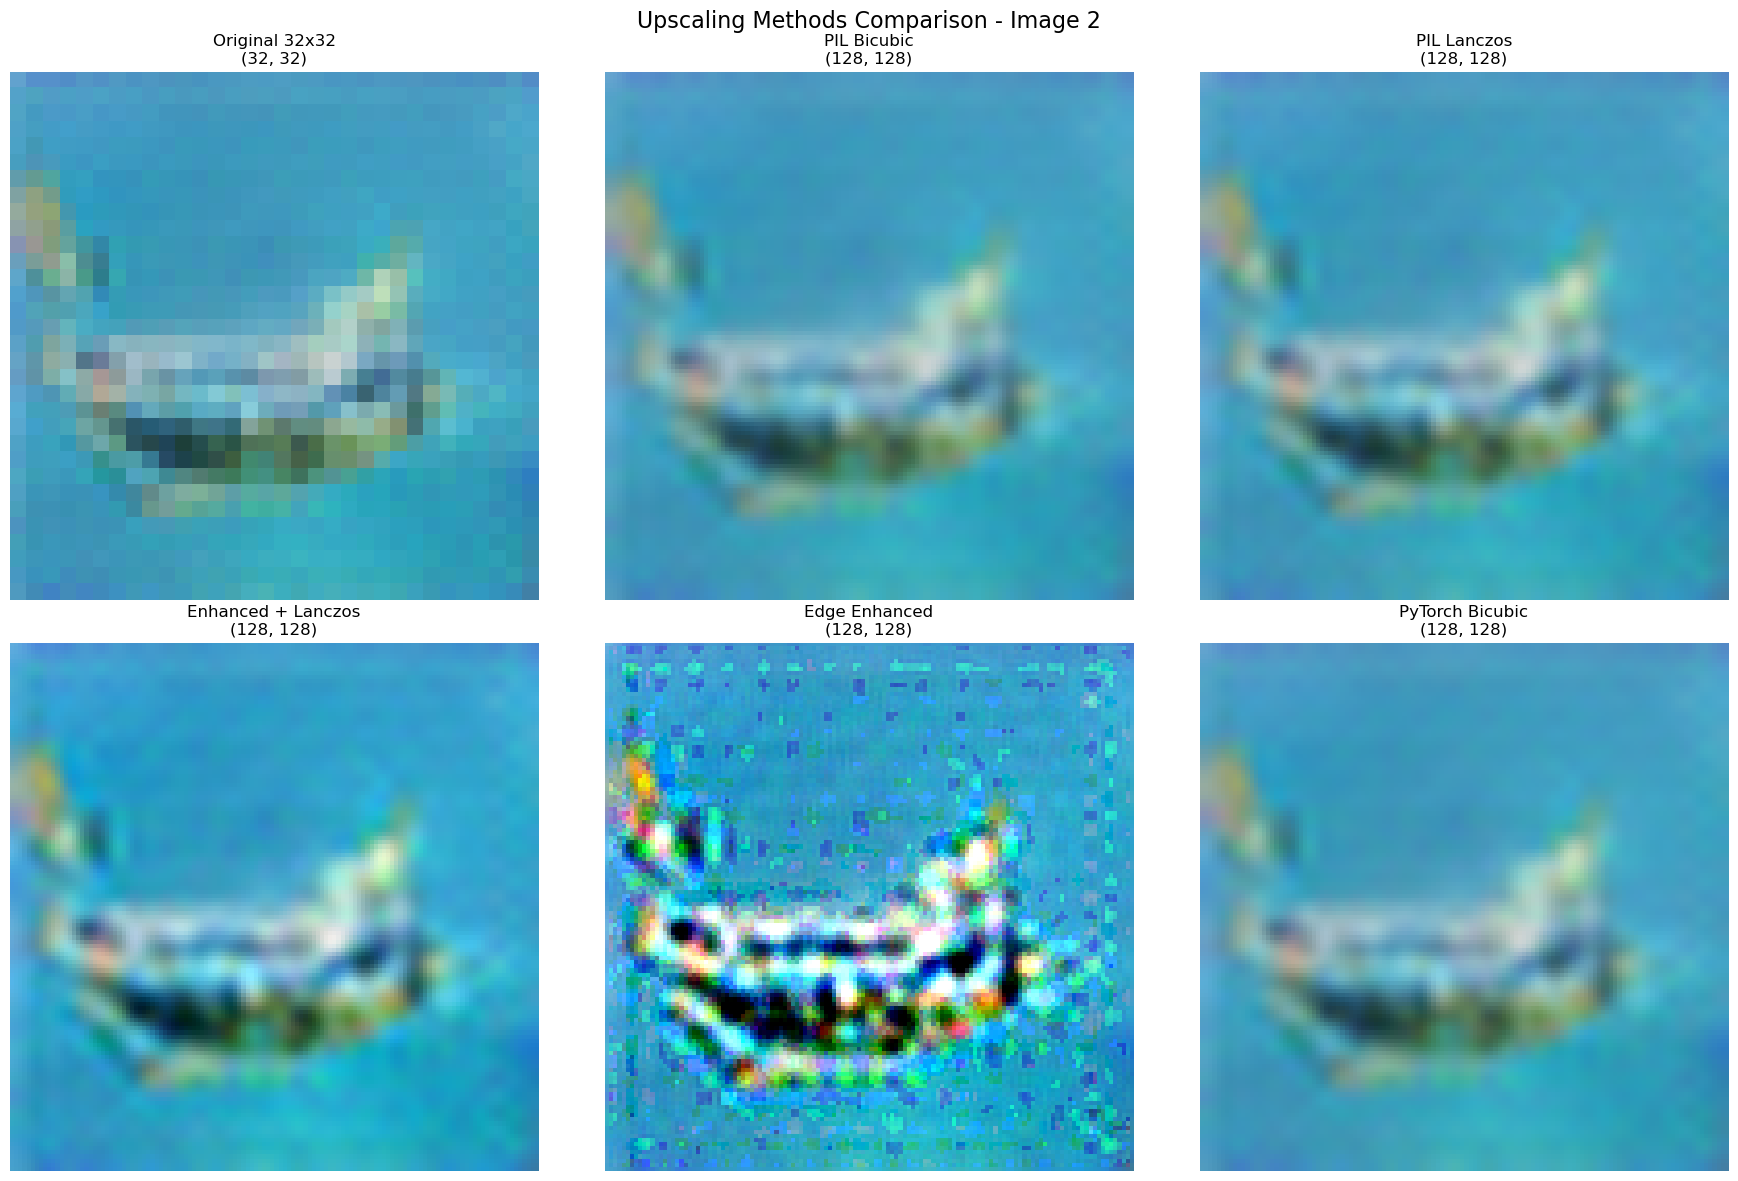

Best quality version saved: generated_images/best_quality_2_20250811_125934.png

✅ Advanced upscaling comparison completed!
Multiple upscaling methods have been compared side by side.


In [16]:
class SimpleESRCN(nn.Module):
    """
    Simple Enhanced Super-Resolution CNN for upscaling generated images
    """
    def __init__(self, scale_factor=4, num_channels=3):
        super(SimpleESRCN, self).__init__()
        self.scale_factor = scale_factor
        
        # Feature extraction layers
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, num_channels * (scale_factor ** 2), kernel_size=5, padding=2)
        
        # Pixel shuffle for upsampling
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        
        # Activation
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.pixel_shuffle(x)
        return torch.clamp(x, 0, 1)

def apply_edge_enhancement(img_pil, strength=1.0):
    """
    Apply edge enhancement to make images appear sharper
    """
    # Apply unsharp mask filter
    enhanced = img_pil.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))
    
    # Apply edge enhancement filter
    enhanced = enhanced.filter(ImageFilter.EDGE_ENHANCE_MORE)
    
    return enhanced

def create_super_resolution_model(scale_factor=4):
    """
    Create and initialize a simple super-resolution model
    """
    model = SimpleESRCN(scale_factor=scale_factor)
    
    # Initialize weights
    def init_weights(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    model.apply(init_weights)
    return model.to(device)

def super_resolve_with_nn(img_tensor, scale_factor=4):
    """
    Apply neural network-based super-resolution
    Note: This uses a simple model for demonstration
    """
    # Create model (in practice, you'd load pre-trained weights)
    sr_model = create_super_resolution_model(scale_factor)
    sr_model.eval()
    
    with torch.no_grad():
        # Normalize input to [0, 1]
        img_normalized = denormalize_image(img_tensor.unsqueeze(0))
        
        # Apply super-resolution
        sr_output = sr_model(img_normalized)
        
    return sr_output.squeeze(0)

def create_multi_method_comparison(img_tensor, scale_factor=4):
    """
    Compare different upscaling methods side by side
    """
    methods_results = {}
    
    # Original
    original_pil = tensor_to_pil(img_tensor)
    methods_results['Original 32x32'] = original_pil
    
    # Method 1: Simple PIL Bicubic
    bicubic_pil = upscale_image_pil(original_pil, (32 * scale_factor, 32 * scale_factor), 'BICUBIC')
    methods_results['PIL Bicubic'] = bicubic_pil
    
    # Method 2: PIL Lanczos
    lanczos_pil = upscale_image_pil(original_pil, (32 * scale_factor, 32 * scale_factor), 'LANCZOS')
    methods_results['PIL Lanczos'] = lanczos_pil
    
    # Method 3: Enhanced quality + Lanczos
    enhanced_pil = enhance_image_quality(img_tensor, True, True)
    enhanced_upscaled = upscale_image_pil(enhanced_pil, (32 * scale_factor, 32 * scale_factor), 'LANCZOS')
    methods_results['Enhanced + Lanczos'] = enhanced_upscaled
    
    # Method 4: Edge enhancement
    edge_enhanced = apply_edge_enhancement(enhanced_upscaled)
    methods_results['Edge Enhanced'] = edge_enhanced
    
    # Method 5: PyTorch bicubic interpolation
    torch_upscaled = upscale_image_bicubic(img_tensor, scale_factor)
    torch_upscaled_pil = tensor_to_pil(torch_upscaled)
    methods_results['PyTorch Bicubic'] = torch_upscaled_pil
    
    return methods_results

def showcase_upscaling_methods(num_samples=2):
    """
    Create a comprehensive comparison of upscaling methods
    """
    print("Creating comprehensive upscaling comparison...")
    
    # Generate test images
    torch.manual_seed(999)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(999)
    
    noise = generate_noise(num_samples, NOISE_DIM, device)
    
    with torch.no_grad():
        test_images = netG(noise)
    
    for idx, img_tensor in enumerate(test_images):
        print(f"\nProcessing image {idx + 1}...")
        
        # Get comparison results
        methods_results = create_multi_method_comparison(img_tensor, scale_factor=4)
        
        # Create subplot for comparison
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for i, (method_name, result_img) in enumerate(methods_results.items()):
            if i < len(axes):
                axes[i].imshow(result_img)
                axes[i].set_title(f"{method_name}\n{result_img.size}", fontsize=12)
                axes[i].axis('off')
        
        # Hide unused subplots
        for i in range(len(methods_results), len(axes)):
            axes[i].set_visible(False)
        
        plt.suptitle(f"Upscaling Methods Comparison - Image {idx + 1}", fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Save the best results
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Save best quality version (Enhanced + Edge Enhancement)
        best_result = methods_results['Edge Enhanced']
        best_filename = os.path.join(output_dir, f"best_quality_{idx+1}_{timestamp}.png")
        best_result.save(best_filename)
        print(f"Best quality version saved: {best_filename}")

# Run the comprehensive comparison
showcase_upscaling_methods(num_samples=2)

print("\n✅ Advanced upscaling comparison completed!")
print("Multiple upscaling methods have been compared side by side.")

### Updated Generation Functions with High-Quality Output

Let's create enhanced versions of our generation functions that automatically apply upscaling and quality improvements.

=== High-Quality Image Generation Demo ===
Generating 8 high-quality images at (256, 256) resolution...
Generated high-quality image 1: generated_images/high_quality_20250811_125942/hq_image_001.png
Generated high-quality image 2: generated_images/high_quality_20250811_125942/hq_image_002.png
Generated high-quality image 3: generated_images/high_quality_20250811_125942/hq_image_003.png
Generated high-quality image 4: generated_images/high_quality_20250811_125942/hq_image_004.png
Generated high-quality image 5: generated_images/high_quality_20250811_125942/hq_image_005.png
Generated high-quality image 6: generated_images/high_quality_20250811_125942/hq_image_006.png
Generated high-quality image 7: generated_images/high_quality_20250811_125942/hq_image_007.png
Generated high-quality image 8: generated_images/high_quality_20250811_125942/hq_image_008.png
Generated high-quality image 7: generated_images/high_quality_20250811_125942/hq_image_007.png
Generated high-quality image 8: generated

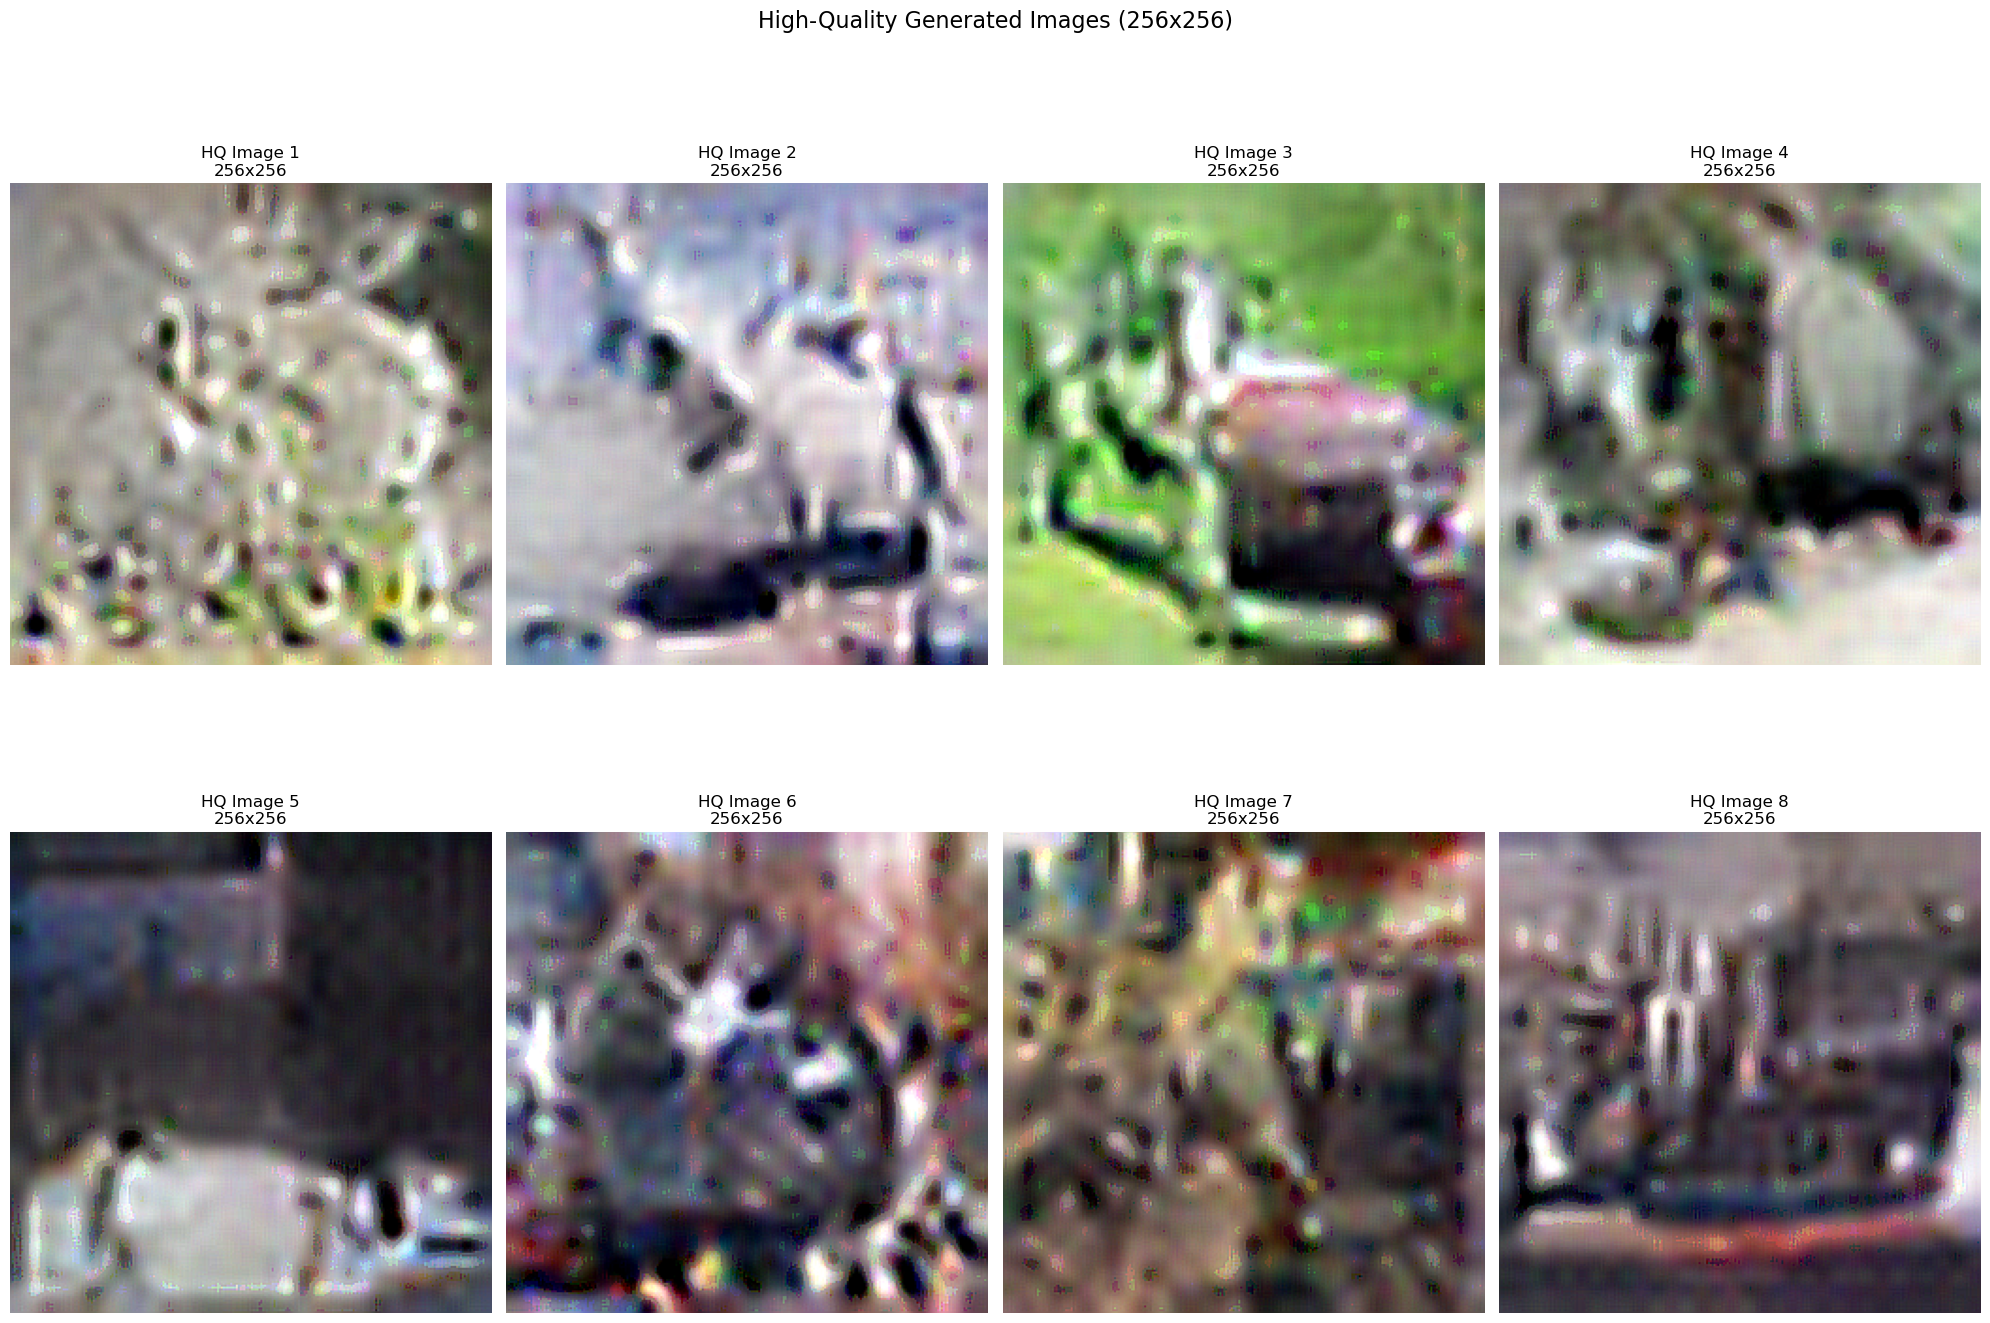


✅ Generated 8 high-quality images
📁 Saved to: generated_images/high_quality_20250811_125942
🖼️  Resolution: 256x256

Generating 4 high-quality images with seed 42...


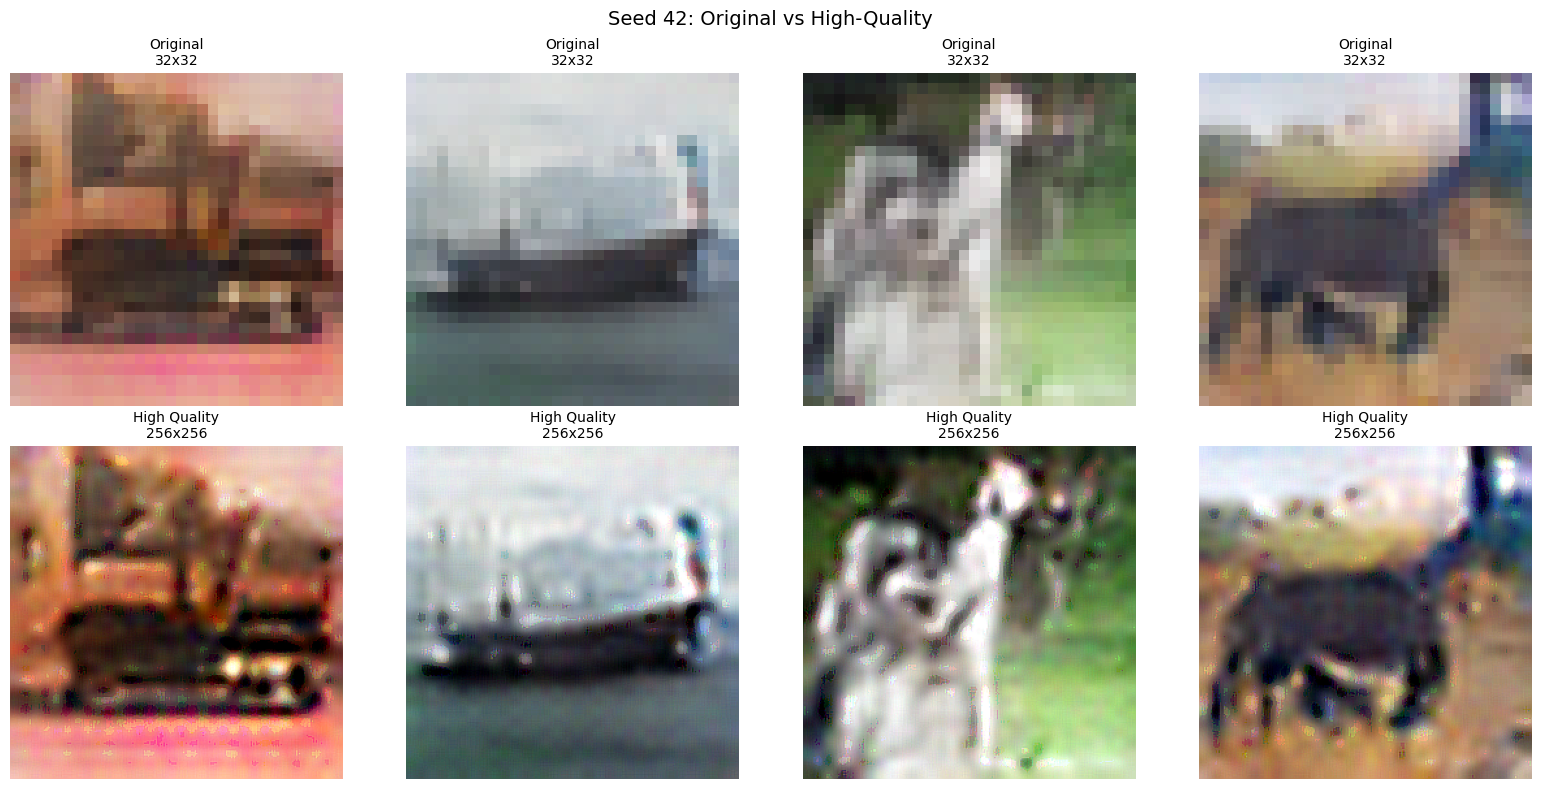

Saved HQ image: generated_images/seed_42_hq_1_20250811_125944.png
Saved HQ image: generated_images/seed_42_hq_2_20250811_125944.png
Saved HQ image: generated_images/seed_42_hq_3_20250811_125944.png
Saved HQ image: generated_images/seed_42_hq_4_20250811_125944.png

Generating ultra-high quality images at 512x512...
Generating 4 high-quality images at (512, 512) resolution...
Generated high-quality image 1: generated_images/high_quality_20250811_125945/hq_image_001.png
Generated high-quality image 2: generated_images/high_quality_20250811_125945/hq_image_002.png
Generated high-quality image 3: generated_images/high_quality_20250811_125945/hq_image_003.png
Generated high-quality image 1: generated_images/high_quality_20250811_125945/hq_image_001.png
Generated high-quality image 2: generated_images/high_quality_20250811_125945/hq_image_002.png
Generated high-quality image 3: generated_images/high_quality_20250811_125945/hq_image_003.png
Generated high-quality image 4: generated_images/high

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

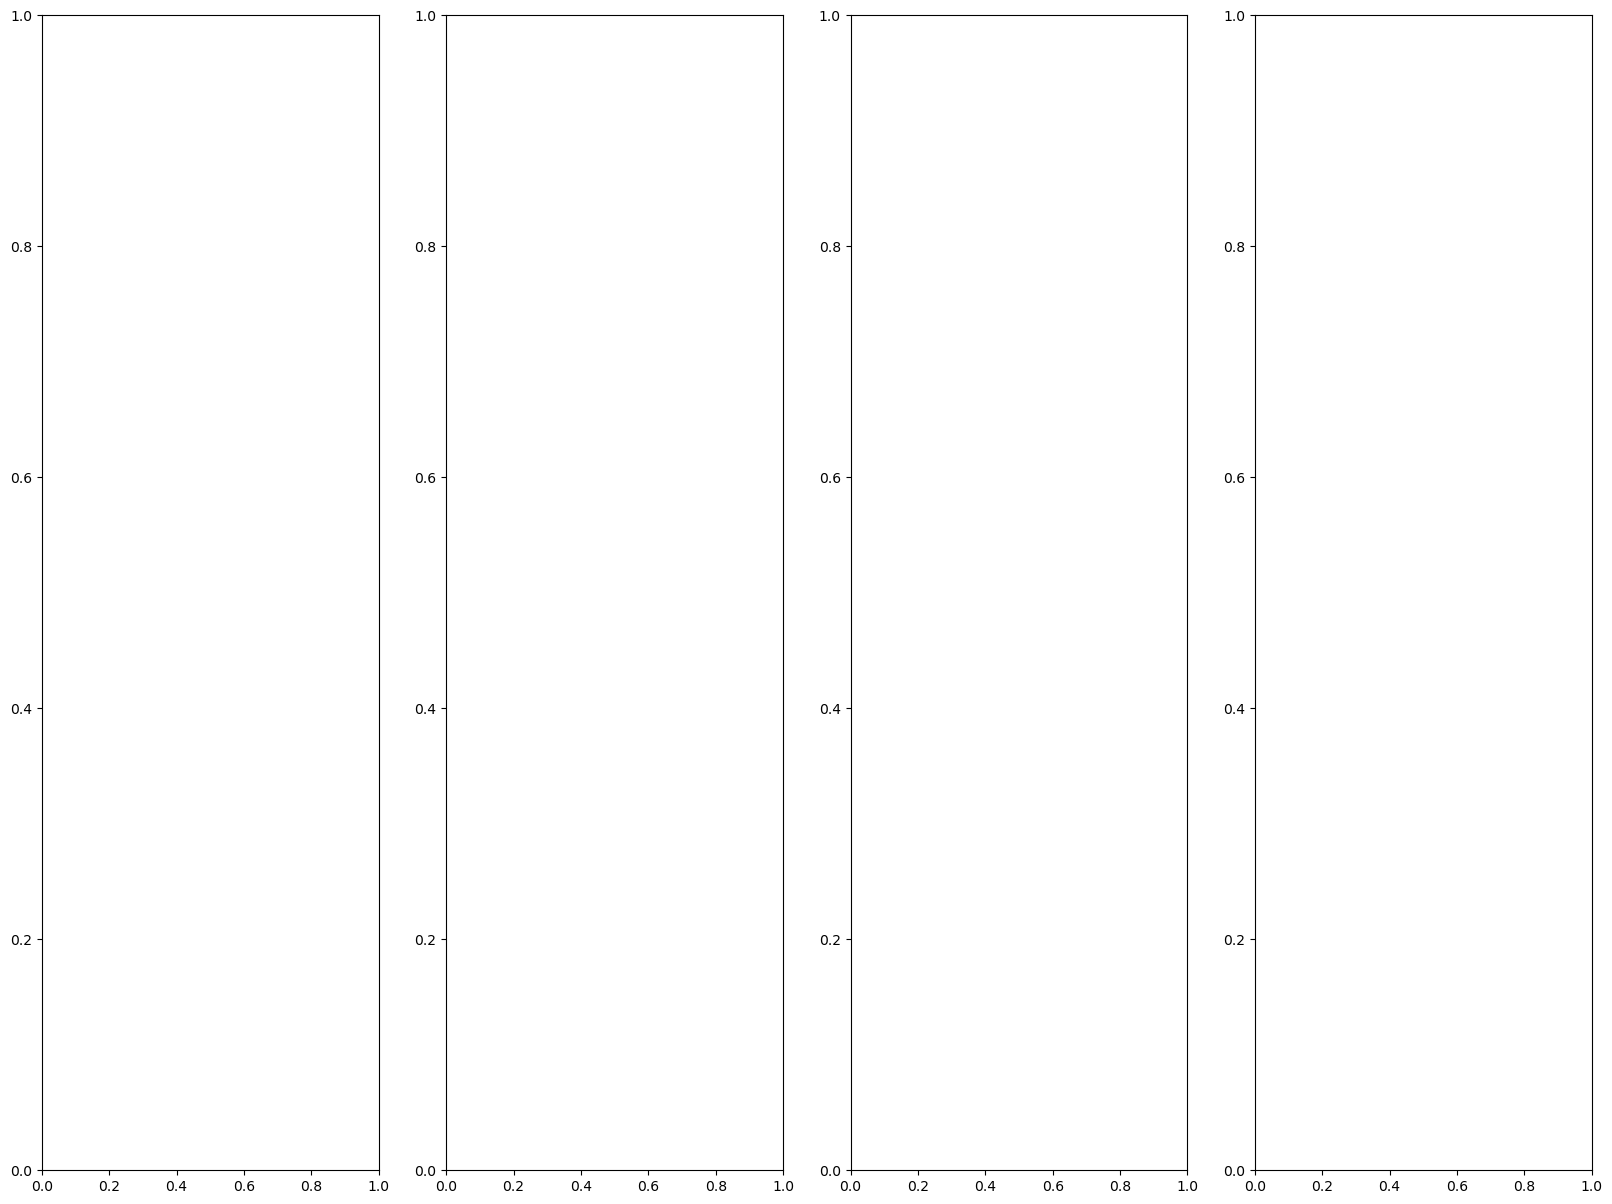

In [17]:
def generate_high_quality_images(num_images=8, target_size=(256, 256), apply_enhancement=True):
    """
    Generate high-quality images with automatic upscaling and enhancement
    
    Args:
        num_images: Number of images to generate
        target_size: Target resolution for upscaled images
        apply_enhancement: Whether to apply quality enhancement
    """
    print(f"Generating {num_images} high-quality images at {target_size} resolution...")
    
    # Generate original images
    noise = generate_noise(num_images, NOISE_DIM, device)
    
    with torch.no_grad():
        original_images = netG(noise)
    
    high_quality_images = []
    filenames = []
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    hq_dir = os.path.join(output_dir, f"high_quality_{timestamp}")
    os.makedirs(hq_dir, exist_ok=True)
    
    for i, img_tensor in enumerate(original_images):
        # Convert to PIL
        img_pil = tensor_to_pil(img_tensor)
        
        # Apply enhancement if requested
        if apply_enhancement:
            img_pil = enhance_image_quality(img_tensor, True, True)
        
        # Upscale to target size
        hq_img = upscale_image_pil(img_pil, target_size, 'LANCZOS')
        
        # Apply edge enhancement for extra sharpness
        hq_img = apply_edge_enhancement(hq_img)
        
        # Save high-quality version
        filename = os.path.join(hq_dir, f"hq_image_{i+1:03d}.png")
        hq_img.save(filename, format='PNG', optimize=True)
        
        high_quality_images.append(hq_img)
        filenames.append(filename)
        
        print(f"Generated high-quality image {i+1}: {filename}")
    
    # Create a grid display
    grid_cols = min(4, num_images)
    grid_rows = (num_images + grid_cols - 1) // grid_cols
    
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(20, 15))
    if num_images == 1:
        axes = [axes]
    elif grid_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, hq_img in enumerate(high_quality_images):
        row = i // grid_cols
        col = i % grid_cols
        
        if grid_rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col]
            
        ax.imshow(hq_img)
        ax.set_title(f"HQ Image {i+1}\n{target_size[0]}x{target_size[1]}", fontsize=12)
        ax.axis('off')
    
    # Hide unused subplots
    for i in range(num_images, grid_rows * grid_cols):
        row = i // grid_cols
        col = i % grid_cols
        if grid_rows > 1:
            axes[row, col].set_visible(False)
        else:
            axes[col].set_visible(False)
    
    plt.suptitle(f"High-Quality Generated Images ({target_size[0]}x{target_size[1]})", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Generated {num_images} high-quality images")
    print(f"📁 Saved to: {hq_dir}")
    print(f"🖼️  Resolution: {target_size[0]}x{target_size[1]}")
    
    return high_quality_images, hq_dir

def generate_with_seed_hq(seed, num_images=4, target_size=(256, 256)):
    """
    Generate high-quality images with a specific seed
    """
    print(f"Generating {num_images} high-quality images with seed {seed}...")
    
    # Set seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
    # Generate noise
    noise = generate_noise(num_images, NOISE_DIM, device)
    
    # Generate images
    with torch.no_grad():
        images = netG(noise)
    
    hq_images = []
    
    for img_tensor in images:
        # Enhance and upscale
        img_pil = enhance_image_quality(img_tensor, True, True)
        hq_img = upscale_image_pil(img_pil, target_size, 'LANCZOS')
        hq_img = apply_edge_enhancement(hq_img)
        hq_images.append(hq_img)
    
    # Display comparison: Original vs HQ
    fig, axes = plt.subplots(2, num_images, figsize=(16, 8))
    
    for i in range(num_images):
        # Original (top row)
        original_pil = tensor_to_pil(images[i])
        axes[0, i].imshow(original_pil)
        axes[0, i].set_title(f"Original\n32x32", fontsize=10)
        axes[0, i].axis('off')
        
        # High-quality (bottom row)
        axes[1, i].imshow(hq_images[i])
        axes[1, i].set_title(f"High Quality\n{target_size[0]}x{target_size[1]}", fontsize=10)
        axes[1, i].axis('off')
    
    plt.suptitle(f"Seed {seed}: Original vs High-Quality", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Save HQ images
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    for i, hq_img in enumerate(hq_images):
        filename = os.path.join(output_dir, f"seed_{seed}_hq_{i+1}_{timestamp}.png")
        hq_img.save(filename)
        print(f"Saved HQ image: {filename}")
    
    return hq_images

# Generate high-quality showcase
print("=== High-Quality Image Generation Demo ===")

# Generate 8 high-quality images at 256x256
hq_images_256, hq_dir_256 = generate_high_quality_images(
    num_images=8, 
    target_size=(256, 256), 
    apply_enhancement=True
)

print("\n" + "="*50)

# Generate with specific seeds in high quality
hq_seed_images = generate_with_seed_hq(seed=42, num_images=4, target_size=(256, 256))

print("\n" + "="*50)

# Generate even higher resolution examples (512x512)
print("Generating ultra-high quality images at 512x512...")
hq_images_512, hq_dir_512 = generate_high_quality_images(
    num_images=4, 
    target_size=(512, 512), 
    apply_enhancement=True
)

print(f"\n🎉 High-quality image generation completed!")
print(f"📁 256x256 images: {hq_dir_256}")
print(f"📁 512x512 images: {hq_dir_512}")
print(f"💡 Tip: The larger the target resolution, the more detailed the upscaled images will appear.")